# SIGNAL PROCESSING TP6 - M2 AI
## To Do: image denoising in wavelet domain

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

---

## IMPORT

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pywt
import tqdm


from nt_toolbox.general import *
from nt_toolbox.signal import *

In [2]:
original_image = cv2.imread('barbara.jpg', cv2.IMREAD_GRAYSCALE)
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

np.random.seed(42)

SNR_LEVELS = [0, 10, 20]

# Different probabilities for Bernoulli mask
P_VALUES = [0.1, 0.5, 0.9]

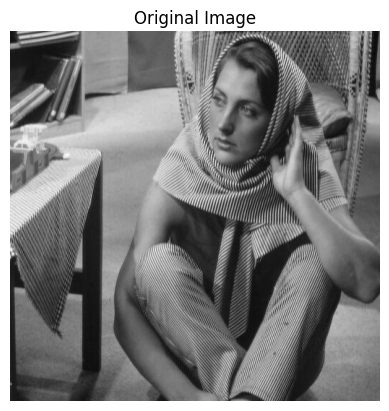

In [3]:
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

## Add noise to the image

In [4]:
def add_noise(signal, snr_db):
    # Compute the variance of the noise
    signal_variance = np.var(signal)
    calculated_noise_variance = signal_variance / np.power(10, snr_db / 10)
    calculated_noise_std = np.sqrt(calculated_noise_variance)
    
    # Introduce noise to the original image
    generated_noise = np.random.normal(0, calculated_noise_std, signal.shape)
    distorted_signal = signal + generated_noise
    
    return distorted_signal

def apply_bernoulli_mask(image, p):
    mask = np.random.binomial(1, p, image.shape)
    return mask

def direct_problem(image, p, SNR):
    # Apply Bernoulli mask to the image
    Ax = apply_bernoulli_mask(image, p) * image
    
    # Add Gaussian noise
    noisy_image = add_noise(image, SNR)
    
    y = Ax + noisy_image  
    return y

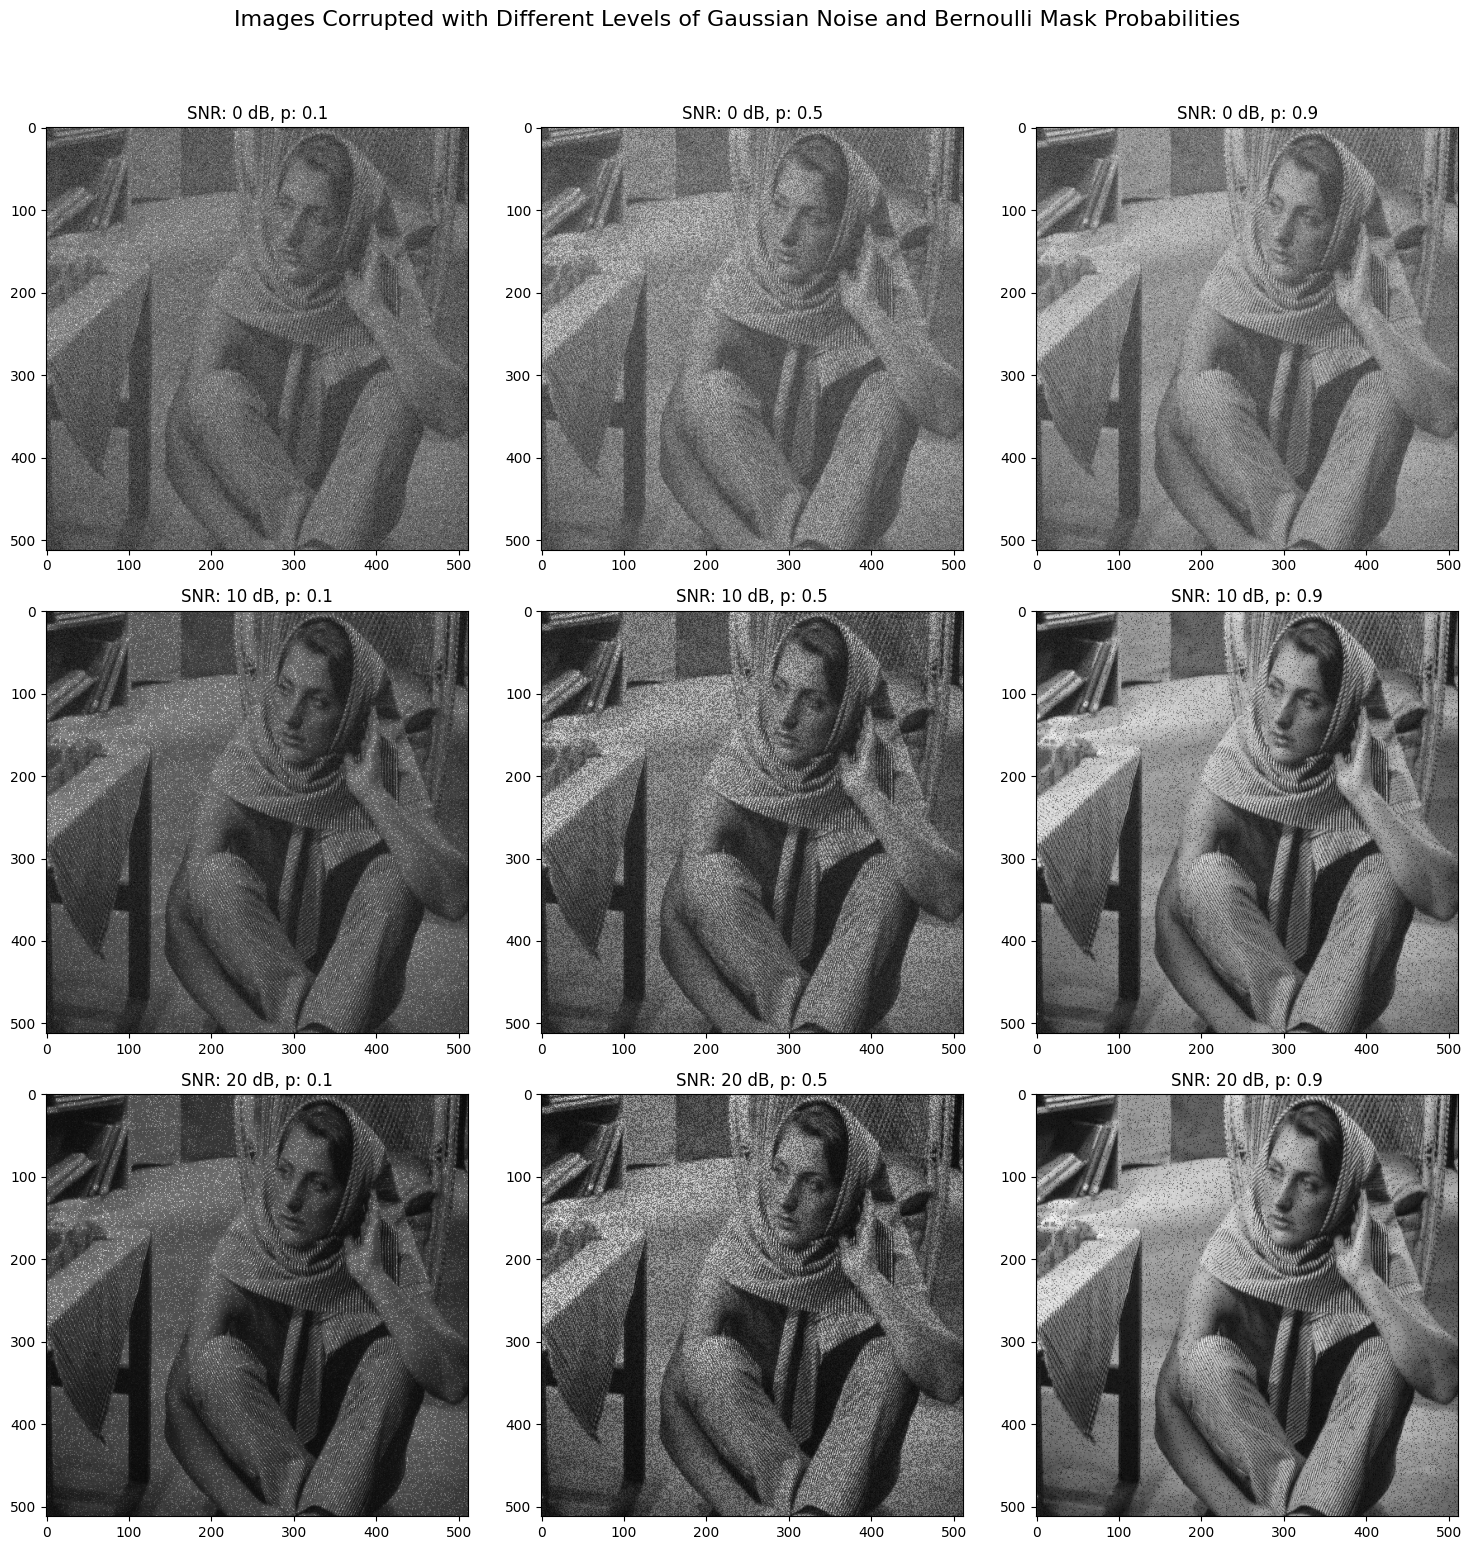

In [5]:
corrupted_images_dict = {(SNR, p): None for SNR in SNR_LEVELS for p in P_VALUES}

# Corrupt the images using Gaussian noise and the Bernoulli mask
for snr in SNR_LEVELS:
    for p in P_VALUES:
        corrupted_img =direct_problem(original_image, p, snr)
        corrupted_images_dict[(snr, p)] = corrupted_img

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, SNR in enumerate(SNR_LEVELS):
    for j, p in enumerate(P_VALUES):
        axes[i, j].imshow(corrupted_images_dict[(SNR, p)], cmap='gray')
        axes[i, j].set_title(f"SNR: {SNR} dB, p: {p}")

fig.suptitle("Images Corrupted with Different Levels of Gaussian Noise and Bernoulli Mask Probabilities", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

---
## Sparse Regularization

To estimate $ x $ from its corrupted version $ y $ using a sparse approach in the wavelet domain, we exploit the fact that images tend to have a sparse representation in the wavelet domain.  

Mathematically, this can be formulated as:

$$
\hat{x} = \arg\min_x \frac{1}{2} \Vert Ax - y \Vert_2^2 + \lambda \Vert Wx \Vert_1
$$

Where:

- $ A $ is the degradation operator (in our case, the Bernoulli mask).
- $ y $ is the observed degraded image.
- $ W $ is the wavelet transform.
- $ \lambda $ is a regularization parameter that balances between the data fidelity term and the sparsity-inducing term.
- The $ L_1 $ norm (denoted by $ \Vert \cdot \Vert_1 $) promotes sparsity in the wavelet coefficients.

In [23]:
def threshold_wavelet_coeffs(wavelet_coeffs, threshold, thresholding_method):
    adjusted_coeffs = wavelet_coeffs.copy()
    
    # Iterate through each set of coefficients
    for idx, coeff in enumerate(adjusted_coeffs):
        
        if not isinstance(coeff, tuple):
            # Apply the thresholding method directly if it's not a tuple
            adjusted_coeffs[idx] = thresholding_method(coeff, threshold)
            
        else:
            # horizontal (cH), vertical (cV), and diagonal (cD).
            horizontal, vertical, diagonal = coeff
            
            # Apply thresholding to each orientation
            adjusted_horizontal = thresholding_method(horizontal, threshold)
            adjusted_vertical = thresholding_method(vertical, threshold)
            adjusted_diagonal = thresholding_method(diagonal, threshold)
            
            # Update the coefficients for this level with the thresholded values
            adjusted_coeffs[idx] = (adjusted_horizontal, adjusted_vertical, adjusted_diagonal)
    return adjusted_coeffs

def thresh_hard(u, t):
    return u*(np.abs(u)>t)

def thresh_soft(u, t):
    return np.maximum(1-t/abs(u), 0)*u 

def fista_sparse_denoising(y, A, W, WT, lambda_val, threshold_method, max_iter=100, step_size=1e-3): # NOT SURE
    """
    Perform sparse denoising using FISTA. 
    
    Parameters:
    - y: observed degraded image
    - A: degradation operator (Bernoulli mask)
    - W: wavelet transform function
    - WT: inverse wavelet transform function
    - lambda_val: regularization parameter
    - max_iter: maximum number of iterations
    - step_size: step size for the gradient descent
    
    Returns:
    - denoised image
    """
    # Initialize x and y (e.g., to the zero image)
    x = np.zeros_like(y)
    y_k = np.zeros_like(y)
    t_k = 1
    
    for _ in range(max_iter):
        # Compute the gradient of the data fidelity term at y_k
        gradient = A * (A * y_k - y)
        
        # Update x using a gradient descent step
        x_next = y_k - step_size * gradient
        
        # Apply the wavelet transform to x_next
        coeffs = W(x_next)
        
        # Threshold the wavelet coefficients using the L1 norm
        coeffs_thresh = threshold_wavelet_coeffs(coeffs, lambda_val * step_size, threshold_method)
        
        # Apply the inverse wavelet transform
        x_next = WT(coeffs_thresh)
        
        # Update y and t for the next iteration
        t_next = (1 + np.sqrt(1 + 4 * t_k**2)) / 2
        y_next = x_next + ((t_k - 1) / t_next) * (x_next - x)
        
        # Update variables for next iteration
        x = x_next
        y_k = y_next
        t_k = t_next
    
    return x 

def denoise_fista(y, A, threshold, thresholding_method, level=None, wavelet='db4', lambda_val=0.01): # NOT SURE
    """
    Denoise an image using FISTA combined with a thresholding technique.
    
    Parameters:
    - y: observed degraded image
    - A: degradation operator (Bernoulli mask)
    - threshold: Threshold value for wavelet coefficients
    - thresholding_method: The method to threshold the wavelet coefficients (e.g., hard or soft thresholding)
    - wavelet: Wavelet type for the wavelet transform
    - lambda_val: Regularization parameter for FISTA
    
    Returns:
    - denoised image
    """
    # Define W and WT for the given wavelet type
    W = lambda x: pywt.wavedec2(x, wavelet, level=level)
    WT = lambda coeffs: pywt.waverec2(coeffs, wavelet)
    
    # Denoise the image using FISTA
    denoised_img = fista_sparse_denoising(y, A, W, WT, lambda_val, thresholding_method)
    
    # Apply thresholding to the wavelet coefficients of the denoised image
    coeffs = W(denoised_img)
    coeffs_thresh = threshold_wavelet_coeffs(coeffs, threshold, thresholding_method)
    
    # Reconstruct the image from the thresholded coefficients
    return WT(coeffs_thresh)

In [18]:
wavelet_types = ["db1", "db2", "db4", "db5", "db10", "db15", "db20", "db25"]
lambda_values = np.linspace(0, 5, 50)
y_demo = corrupted_images_dict[(0, 0.1)]
A_demo = apply_bernoulli_mask(original_image, 0.1)

## Hard Thresholding

Hard Thresholding ~25 mins time execution

In [ ]:
snr_data = {wt: [] for wt in wavelet_types}

for wt in tqdm.tqdm(wavelet_types):
    for lambda_val in lambda_values:
        denoised_img = denoise_fista(y_demo, A_demo, 2.6, thresh_hard, level=None, wavelet='db4', lambda_val=lambda_val)
        
        # Compute SNR
        snr_val = 10 * np.log10(np.var(original_image) / np.var(original_image - denoised_img))
        snr_data[wt].append(snr_val)

plt.figure(figsize=(12, 7))
for wt, snr_values in snr_data.items():
    plt.plot(lambda_values, snr_values, label=wt)

plt.legend(loc="upper right")
plt.title("[Hard Thresholding] SNR vs Threshold Coefficient for Different Wavelets using FISTA")
plt.xlabel("Threshold Value")
plt.ylabel("Denoised SNR")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

We should put the best lambda below

/var/folders/wp/rnrfxcyd06x0vdh1xjfdtmqr0000gn/T/ipykernel_27152/1865996070.py:28: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(1-t/abs(u), 0)*u


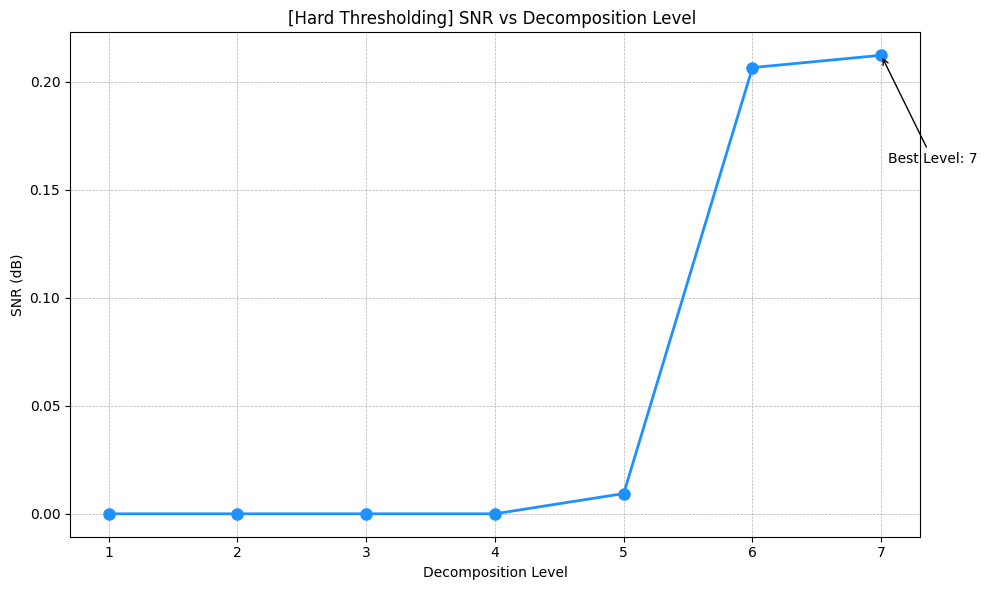

In [25]:
decomposition_levels = list(range(1, 8))
snr_values_per_level = []

for current_level in decomposition_levels:
    
    # Denoise the image using the PyWavelets method at the current decomposition level
    denoised_image = denoise_fista(y_demo, A_demo, 2.6, thresh_soft, level=current_level)
    
    # Compute the Signal-to-Noise Ratio (SNR) for the denoised image
    current_snr = 10 * np.log10(np.var(original_image) / np.var(original_image - denoised_image))
    snr_values_per_level.append(current_snr)

# Identify the best decomposition level based on highest SNR
max_snr_value_hard = max(snr_values_per_level)
best_hard_level = decomposition_levels[snr_values_per_level.index(max_snr_value_hard)]

plt.figure(figsize=(10, 6))
plt.plot(decomposition_levels, snr_values_per_level, 'o-', markersize=8, linewidth=2, color='dodgerblue')

plt.annotate(f"Best Level: {best_hard_level}", 
             xy=(best_hard_level, max_snr_value_hard), 
             xytext=(best_hard_level + 0.05, max_snr_value_hard - 0.05), 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

plt.title("[Hard Thresholding] SNR vs Decomposition Level ")
plt.xlabel("Decomposition Level")
plt.ylabel("SNR (dB)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Soft Thresholding

Soft Thresholding ~20 mins time execution

  0%|          | 0/8 [00:00<?, ?it/s]/var/folders/wp/rnrfxcyd06x0vdh1xjfdtmqr0000gn/T/ipykernel_27152/3280133261.py:28: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(1-t/abs(u), 0)*u
/var/folders/wp/rnrfxcyd06x0vdh1xjfdtmqr0000gn/T/ipykernel_27152/3280133261.py:28: RuntimeWarning: invalid value encountered in divide
  return np.maximum(1-t/abs(u), 0)*u
100%|██████████| 8/8 [21:37<00:00, 162.23s/it]


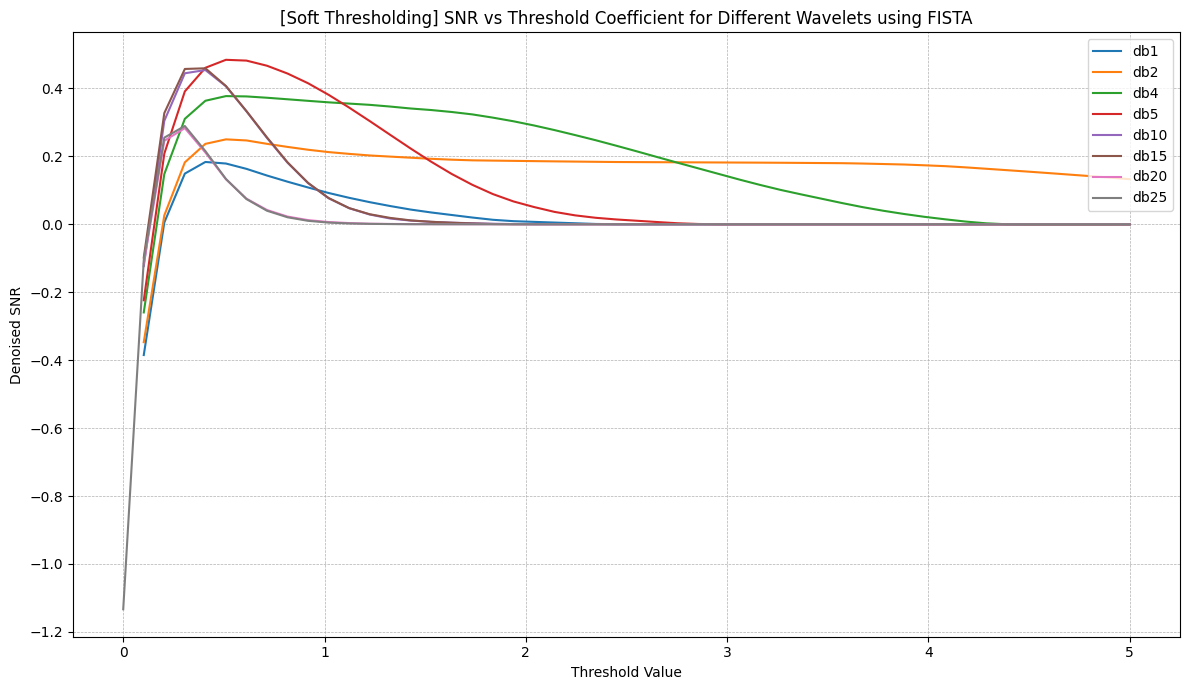

In [20]:
snr_data = {wt: [] for wt in wavelet_types}

for wt in tqdm.tqdm(wavelet_types):
    for threshold in lambda_values:
        denoised_img = denoise_fista(y_demo, A_demo, 1.6, thresh_soft, level=None, wavelet='db4', lambda_val=lambda_val)
        
        # Compute SNR
        snr_val = 10 * np.log10(np.var(original_image) / np.var(original_image - denoised_img))
        snr_data[wt].append(snr_val)

plt.figure(figsize=(12, 7))
for wt, snr_values in snr_data.items():
    plt.plot(lambda_values, snr_values, label=wt)

plt.legend(loc="upper right")
plt.title("[Soft Thresholding] SNR vs Threshold Coefficient for Different Wavelets using FISTA")
plt.xlabel("Threshold Value")
plt.ylabel("Denoised SNR")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

We should put the best lambda below

/var/folders/wp/rnrfxcyd06x0vdh1xjfdtmqr0000gn/T/ipykernel_27152/1865996070.py:28: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(1-t/abs(u), 0)*u
/Users/kentrachmat/Desktop/ai_paper_challenge_codabench/.conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


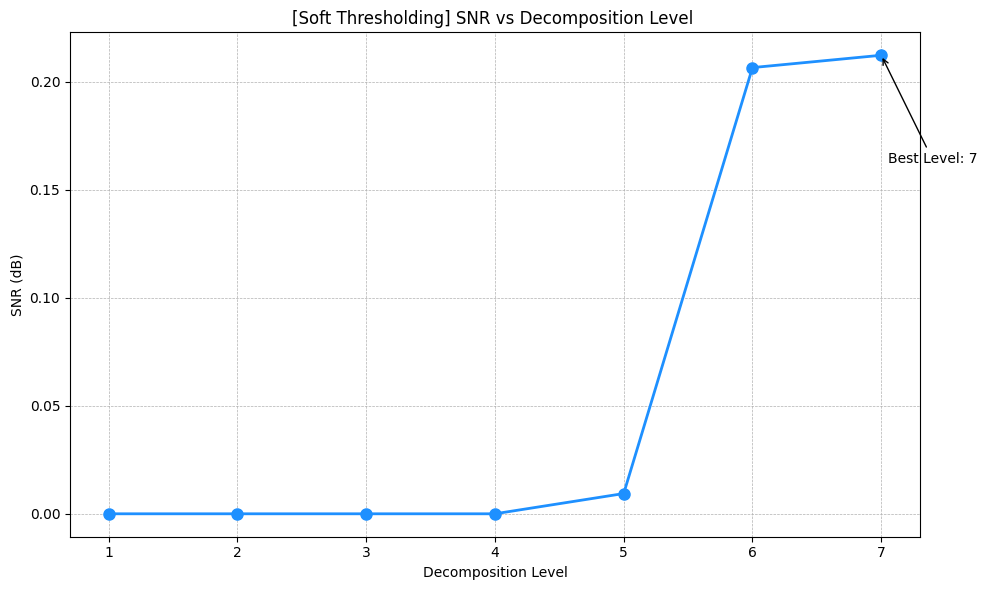

In [28]:
decomposition_levels = list(range(1, 8))
snr_values_per_level = []

for current_level in decomposition_levels:
    
    # Denoise the image using the PyWavelets method at the current decomposition level
    denoised_image = denoise_fista(y_demo, A_demo, 2.6, thresh_soft, level=current_level)
    
    # Compute the Signal-to-Noise Ratio (SNR) for the denoised image
    current_snr = 10 * np.log10(np.var(original_image) / np.var(original_image - denoised_image))
    snr_values_per_level.append(current_snr)

# Identify the best decomposition level based on highest SNR
max_snr_value_soft = max(snr_values_per_level)
best_soft_level = decomposition_levels[snr_values_per_level.index(max_snr_value_soft)]

plt.figure(figsize=(10, 6))
plt.plot(decomposition_levels, snr_values_per_level, 'o-', markersize=8, linewidth=2, color='dodgerblue')

plt.annotate(f"Best Level: {best_soft_level}", 
             xy=(best_soft_level, max_snr_value_soft), 
             xytext=(best_soft_level + 0.05, max_snr_value_soft - 0.05), 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

plt.title("[Soft Thresholding] SNR vs Decomposition Level ")
plt.xlabel("Decomposition Level")
plt.ylabel("SNR (dB)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

empirical Wiener? 
How to get the best threshold?

the sparse respresentation (various wavelet orhtogonal transform and translation invariant wavelets)